# Análise de Absentismo - Call Center

**Objetivo:** Análise descritiva e prescritiva de padrões de absentismo.

**Dataset:** 1.3M registos, 3,135 colaboradores, 18 meses (2024-01 a 2025-06)

---

## GRUPO 1: PREPARAÇÃO E LIMPEZA DE DADOS

#### 1. Imports

In [6]:
# Imports
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime, timedelta
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

print('Bibliotecas carregadas')

Bibliotecas carregadas


#### 1.1 Carregar dados

In [8]:
print('PASSO 1.1: Carregar dados')
print('-' * 70)

# Dataset principal
df_raw = pd.read_csv('combined_data.csv')
df_raw['Data'] = pd.to_datetime(df_raw['Data'])

print(f'Dataset carregado:')
print(f'  Registos: {len(df_raw):,}')
print(f'  Colaboradores: {df_raw["login_colaborador"].nunique():,}')
print(f'  Periodo: {df_raw["Data"].min().date()} ate {df_raw["Data"].max().date()}')

# Nova classificação
df_codigos = pd.read_excel('códigos_V2.xlsx')

print(f'\nClassificacao carregada:')
print(f'  Codigos: {len(df_codigos)}')
print(f'  Nivel 1 (categorias): {df_codigos["Nivel 1"].nunique()}')
print(f'  Nivel 2 (subcategorias): {df_codigos["Nivel 2"].nunique()}')

PASSO 1.1: Carregar dados
----------------------------------------------------------------------
Dataset carregado:
  Registos: 1,325,097
  Colaboradores: 3,135
  Periodo: 2024-01-01 ate 2025-06-30

Classificacao carregada:
  Codigos: 56
  Nivel 1 (categorias): 5
  Nivel 2 (subcategorias): 13


#### 1.2 Aplicar classificação

In [10]:
print('\nPASSO 1.2: Aplicar classificacao')
print('-' * 70)

df_temp = df_raw.merge(
    df_codigos,
    left_on='segmento_processado_codigo',
    right_on='Codigo Segmento',
    how='left'
)

# Verificar mapeamento
sem_classificacao = df_temp['Nivel 1'].isna().sum()

if sem_classificacao == 0:
    print('OK: Todos os codigos mapeados')
else:
    print(f'AVISO: {sem_classificacao} registos sem classificacao')

print(f'\nTotal registos: {len(df_temp):,}')


PASSO 1.2: Aplicar classificacao
----------------------------------------------------------------------
OK: Todos os codigos mapeados

Total registos: 1,325,097


#### 1.3 Identificar incompatibilidades

In [12]:
print('\nPASSO 1.3: Identificar incompatibilidades')
print('-' * 70)

# Matriz de compatibilidade (Nivel 2)
compat_rules = pd.DataFrame([
    # Compativeis
    ['Presença', 'Atraso', 1],
    ['Presença', 'Formação', 1],
    
    
    # Incompativeis
    ['Presença', 'Ausência Médica', 0],
    ['Presença', 'Ausência Injustificada', 0],
    ['Presença', 'Licença Mat/Pat', 0],
    ['Presença', 'Férias', 0],
    ['Presença', 'Falta Justificada', 0],
    ['Presença', 'Ferias / Feriado / Folga', 0],
    ['Trabalho Pago', 'Ausência Médica', 0],
    ['Trabalho Pago', 'Falta Injustificada', 0],
], columns=['cat1', 'cat2', 'compativel'])

# Criar dicionário
compat_dict = {}
for _, row in compat_rules.iterrows():
    key = tuple(sorted([row['cat1'], row['cat2']]))
    compat_dict[key] = row['compativel']

print(f'Regras de compatibilidade: {len(compat_dict)}')

# Identificar dias com multiplos registos
dias_mult = df_temp.groupby(['login_colaborador', 'Data']).size()
dias_mult = dias_mult[dias_mult > 1].reset_index()
dias_mult.columns = ['login_colaborador', 'Data', 'num_registos']

print(f'\nDias com multiplos registos: {len(dias_mult):,}')

# Pre-filtrar e agrupar (otimizado)
dias_mult_idx = list(zip(dias_mult['login_colaborador'], dias_mult['Data']))
df_mult = df_temp[df_temp.set_index(['login_colaborador', 'Data']).index.isin(dias_mult_idx)]

df_mult_grouped = df_mult.groupby(['login_colaborador', 'Data']).agg({
    'Nivel 2': lambda x: list(x.dropna().unique()),
    'segmento_processado_codigo': lambda x: list(x.unique()),
    'nome_colaborador': 'first'
}).reset_index()

print(f'Dias unicos a testar: {len(df_mult_grouped):,}')

# Testar pares
print('\nTestando incompatibilidades...')
incompativeis = []

for idx, row in df_mult_grouped.iterrows():
    if idx % 10000 == 0 and idx > 0:
        print(f'  Processados {idx:,}/{len(df_mult_grouped):,}')
    
    categorias = row['Nivel 2']
    pares_incompat = []
    
    for i, cat1 in enumerate(categorias):
        for cat2 in categorias[i+1:]:
            key = tuple(sorted([cat1, cat2]))
            if key in compat_dict and compat_dict[key] == 0:
                pares_incompat.append(f'{cat1} + {cat2}')
    
    if pares_incompat:
        incompativeis.append({
            'login_colaborador': row['login_colaborador'],
            'Data': row['Data'],
            'nome_colaborador': row['nome_colaborador'],
            'categorias': ', '.join(categorias),
            'pares_incompativeis': ' | '.join(pares_incompat)
        })

df_incompativeis = pd.DataFrame(incompativeis)

print(f'\nRESULTADO: {len(df_incompativeis)} dias incompativeis encontrados')

if len(df_incompativeis) > 0:
    print('\nDistribuicao por tipo de incompatibilidade:')
    
    # Contar cada par
    todos_pares = []
    for pares_str in df_incompativeis['pares_incompativeis']:
        todos_pares.extend(pares_str.split(' | '))
    
    pares_count = pd.Series(todos_pares).value_counts()
    
    for par, count in pares_count.items():
        print(f'  {par:50s}: {count:3d} casos')
    
    # Exportar
    df_incompativeis.to_excel('incompatibilidades_detalhadas.xlsx', index=False)
    print('\nExportado: incompatibilidades_detalhadas.xlsx')


PASSO 1.3: Identificar incompatibilidades
----------------------------------------------------------------------
Regras de compatibilidade: 10

Dias com multiplos registos: 494,472
Dias unicos a testar: 494,472

Testando incompatibilidades...
  Processados 10,000/494,472
  Processados 20,000/494,472
  Processados 30,000/494,472
  Processados 40,000/494,472
  Processados 50,000/494,472
  Processados 60,000/494,472
  Processados 70,000/494,472
  Processados 80,000/494,472
  Processados 90,000/494,472
  Processados 100,000/494,472
  Processados 110,000/494,472
  Processados 120,000/494,472
  Processados 130,000/494,472
  Processados 140,000/494,472
  Processados 150,000/494,472
  Processados 160,000/494,472
  Processados 170,000/494,472
  Processados 180,000/494,472
  Processados 190,000/494,472
  Processados 200,000/494,472
  Processados 210,000/494,472
  Processados 220,000/494,472
  Processados 230,000/494,472
  Processados 240,000/494,472
  Processados 250,000/494,472
  Processados 2

#### 1.4 Remover entradas incompativeis

In [14]:
print('\nPASSO 1.4: Remover dias incompativeis')
print('-' * 70)

if len(df_incompativeis) > 0:
    # Criar indice para remover
    idx_remover = df_temp.set_index(['login_colaborador', 'Data']).index.isin(
        list(zip(df_incompativeis['login_colaborador'], df_incompativeis['Data']))
    )
    
    registos_removidos = idx_remover.sum()
    
    df_limpo = df_temp[~idx_remover].copy()
    
    print(f'Registos removidos: {registos_removidos:,}')
    print(f'Dataset limpo: {len(df_limpo):,} registos')
else:
    df_limpo = df_temp.copy()
    print('Nenhum registo a remover')
    print(f'Dataset limpo: {len(df_limpo):,} registos')


PASSO 1.4: Remover dias incompativeis
----------------------------------------------------------------------
Registos removidos: 96
Dataset limpo: 1,325,001 registos


#### 1.5 Agregar categorias Profissionais

In [16]:
# Exploração de categorias profissionais
print('CATEGORIAS PROFISSIONAIS EXISTENTES:')
print('='*70)

categorias = df_limpo['categoria_profissional'].value_counts()
print(f'\nTotal de categorias únicas: {len(categorias)}')
print(f'\nTodas as categorias:')
for cat, count in categorias.items():
    print(f'   {cat}')

CATEGORIAS PROFISSIONAIS EXISTENTES:

Total de categorias únicas: 151

Todas as categorias:
   ASSISTENTE DE CONTACT CENTER (N1)
   ASSISTENTE DE CONTACT CENTER (N3)
   ASSISTENTE DE CONTACT CENTER (N2)
   DELEGADO COMERCIAL
   ASSISTENTE DE CALL CENTER
   SUPERVISOR OPERACIONAL
   BRIGADISTA
   AUXILIAR DE LIMPEZA
   ASSISTENTE DE CONTACT CENTER (N4)
   TÉCNICO DE GESTÃO DE QUALIDADE
   ESTAGIÁRIO
   ASSISTENTE DE CALL CENTER - SERV SEGMENTADOS
   SUPERVISOR OPERACIONAL - ESTAGIÁRIO
   GESTOR DE SALA
   ASSISTENTE DE CINEMA
   SUPERVISOR OPERACIONAL - SERVIÇOS SEGMENTADOS
   FORMADOR
   ASSISTENTE DE CALL CENTER - SERV PARTILHADOS
   PROGRAMADOR
   RECEPCIONISTA
   COORDENADOR OPERACIONAL
   TÉCNICO DE INFORMÁTICA
   ASSISTENTE DE LOJA
   SUPERVISOR UNITEL MONEY - BRIGADISTAS Outsourcing
   FIEL DE ARMAZEM
   SUPERVISOR OPERACIONAL - OUTSOURCING
   GESTOR DE CONTA
   TÉCNICO DE GESTÃO DE QUALIDADE - ESTAGIÁRIO
   ASSISTENTE BACKOFFICE - SWAT
   ASSISTENTE DE MANUTENÇÃO
   ASSISTENTE D

In [17]:
# ======================================================================
# 1.X NORMALIZAR CATEGORIAS PROFISSIONAIS
# ======================================================================

print('\nPASSO 1.X: Normalizar categorias profissionais')
print('-' * 70)

# Dicionário de mapeamento (baseado no teu)
categorias_agregadas = {
    # Contact / Call Center
    "ASSISTENTE DE CONTACT CENTER (N1)": "Assistente de Contact Center",
    "ASSISTENTE DE CONTACT CENTER (N2)": "Assistente de Contact Center",
    "ASSISTENTE DE CONTACT CENTER (N3)": "Assistente de Contact Center",
    "ASSISTENTE DE CONTACT CENTER (N4)": "Assistente de Contact Center",
    "ASSISTENTE DE CALL CENTER": "Assistente de Contact Center",
    "ASSISTENTE DE CALL CENTER - SERV SEGMENTADOS": "Assistente de Contact Center",
    "ASSISTENTE DE CALL CENTER - SERV PARTILHADOS": "Assistente de Contact Center",
    "ASSISTENTE DE CALL CENTER - SUPORTE TÉCNICO": "Assistente de Contact Center",
    "ASSISTENTE DE CALL CENTER - BACK OFFICE": "Assistente de Contact Center",
    "ASSISTENTE DE CALL CENTER - UMBI UMBI CLUB": "Assistente de Contact Center",
    "ASSISTENTE BACKOFFICE - SWAT": "Assistente Backoffice",

    # Experiência de Cliente
    "ASSISTENTE DE EXPERIÊNCIA DE CLIENTE N1": "Assistente de Contact Center",
    "ASSISTENTE DE EXPERIÊNCIA DE CLIENTE N2": "Assistente de Contact Center",
    "ASSISTENTE DE EXPERIÊNCIA DE CLIENTE N3": "Assistente de Contact Center",
    "GESTOR DE GESTÃO DE EXPERIÊNCIA DE CLIENTE": "Gestor de Experiência do Cliente",
    "TÉCNICO DE GESTÃO DE EXPERIÊNCIA DE CLIENTE": "Técnico de Experiência do Cliente",

    # Vendas & Comercial
    "DELEGADO COMERCIAL": "Comercial",
    "PROMOTOR DE VENDAS": "Promotor de Vendas",
    "CONSULTOR COMERCIAL JR": "Consultor Comercial",
    "VENDEDOR": "Vendas",
    "AGENTE DE VENDAS": "Vendas",
    "ASSISTENTE DE VENDAS": "Assistente de Vendas",
    "SUPERVISOR DE VENDAS": "Supervisor de Vendas",
    "CONSULTOR": "Consultor",

    # Loja / Cinema
    "ASSISTENTE DE LOJA": "Assistente de Loja",
    "ASSISTENTE DE LOJAS": "Assistente de Loja",
    "ASSISTENTE DE CAIXA": "Assistente de Loja",
    "ASSISTENTE DE CINEMA": "Assistente de Loja",
    "BALCONISTA": "Atendimento Balcão",
    "DINAMIZADOR DE BALCÃO": "Atendimento Balcão",
    "EMPREGADO DE BALCAO": "Atendimento Balcão",

    # Supervisores Operacionais
    "SUPERVISOR OPERACIONAL": "Supervisor Operacional",
    "SUPERVISOR OPERACIONAL - SERVIÇOS SEGMENTADOS": "Supervisor Operacional",
    "SUPERVISOR OPERACIONAL - OUTSOURCING": "Supervisor Operacional",
    "SUPERVISOR OPERACIONAL - ESTAGIÁRIO": "Supervisor Operacional",
    "SUPERVISOR OPERACIONAL -  OUTSOURCING ESTAGIÁRIO": "Supervisor Operacional",
    "SUPERVISOR- ESTAGIÁRIO": "Supervisor Operacional",
    
    # Coordenadores Operacionais
    "COORDENADOR OPERACIONAL": "Coordenador Operacional",
    "COORDENADOR OPERACIONAL - ESTAGIÁRIO": "Coordenador Operacional",

    # Brigadistas (categoria específica)
    "BRIGADISTA": "Brigadista",
    "SUPERVISOR UNITEL MONEY - BRIGADISTAS Outsourcing": "Supervisor Brigadistas",  
    "COORDENADOR UNITEL MONEY - BRIGADISTAS Outsourcing": "Coordenador Brigadistas",  
    
    # Limpeza / Facilities (categorias SEPARADAS)
    "AUXILIAR DE LIMPEZA": "Auxiliar de Limpeza",
    "SUPERVISOR DE LIMPEZA": "Supervisor de Limpeza",
    "SUPERVISOR DE SERVIÇOS GERAIS": "Supervisor de Serviços Gerais",
    "DIRECTOR DE SERVIÇOS GERAIS": "Diretor de Serviços Gerais",
    "GOVERNANTA": "Serviços Gerais",

    # Recursos Humanos
    "ASSISTENTE DE RECURSOS HUMANOS": "Assistente de RH",
    "TÉCNICO  DE RECURSOS HUMANOS": "Técnico de RH",
    "COORDENADOR DE RECURSOS HUMANOS": "Coordenador de RH",
    "GESTOR  DE RECURSOS HUMANOS": "Gestor de RH",
    "TÉCNICO DE DESENVOLVIMENTO DE CAPITAL HUMANO": "Técnico de RH",
    "GESTOR DE DESENVOLVIMENTO DE CAPITAL HUMANO": "Gestor de RH",
    "TECNICO DE RECRUTAMENTO E SELECÇÃO": "Técnico de Recrutamento",
    "COORDENADOR DE RECRUTAMENTO E SELECÇÃO": "Coordenador de Recrutamento",
    "GESTOR DE RECRUTAMENTO": "Gestor de Recrutamento",
    "ASSISTENTE DE RECRUTAMENTO E SELECÇÃO": "Assistente de Recrutamento",
    "DIRECTOR DE PESSOAS": "Diretor de RH",

    # Formação
    "FORMADOR": "Formador",
    "FORMADOR - ESTAGIÁRIO": "Formador",
    "GESTOR DE ACADEMIA DE FORMAÇÃO": "Gestor de Formação",
    "COORDENADOR DA ACADEMIA DA  FORMAÇÃO": "Coordenador de Formação",

    # Qualidade / Auditoria
    "TÉCNICO DE GESTÃO DE QUALIDADE": "Técnico de Qualidade",
    "TÉCNICO DE GESTÃO DE QUALIDADE - ESTAGIÁRIO": "Técnico de Qualidade",
    "SUPERVISOR DE GESTÃO DE QUALIDADE": "Supervisor de Qualidade",
    "AUDITOR DE QUALIDADE": "Auditor de Qualidade",
    "COORDENADOR DE AUDITORIA E CONTROLO DE QUALIDADE": "Coordenador de Qualidade",

    # Finanças & Contabilidade
    "TÉCNICO DE CONTABILIDADE": "Técnico de Contabilidade",
    "ASSISTENTE DE CONTABILIDADE": "Assistente de Contabilidade",
    "ASSISTENTE DE CONTABILIDADE - ESTAGIÁRIO": "Assistente de Contabilidade",
    "TÉCNICO DE CONTAS": "Técnico Financeiro",
    "TÉCNICO DE TESOURARIA": "Técnico de Tesouraria",
    "ASSISTENTE DE TESOURARIA": "Assistente de Tesouraria",
    "COORDENADOR DE TESOURARIA": "Coordenador de Tesouraria",
    "DIRECTOR FINANCEIRO": "Diretor Financeiro",

    # TI / Sistemas / Desenvolvimento
    "TÉCNICO DE INFORMÁTICA": "Técnico Informática",
    "TÉCNICO DE HELPDESK": "Helpdesk",
    "COORDENADOR DE HELPDESK": "Coordenador Helpdesk",
    "ADMINISTRADOR DE SISTEMAS": "Administrador de Sistemas",
    "DIRECTOR DE SISTEMAS DE INFORMAÇÃO": "Diretor de Sistemas",
    "DIRECTOR ADJUNTO DE SISTEMAS": "Diretor de Sistemas",
    "ADMINISTRADOR DE REDES E TELECOMUNICAÇÕES": "Administrador Redes",
    "ANALISTA DE SUPORTES INFORMÁTICO": "Analista de Suporte",
    "TÉCNICO DE REDES E TELECOMUNICAÇÕES": "Técnico Redes",
    "TÉCNICO DE BASE DE DADOS": "Técnico Base de Dados",
    "COORDENADOR DE BASE DE DADOS E VOZ": "Coordenador Base Dados e Voz",
    "PROGRAMADOR": "Programador",
    "PROGRAMADOR - ESTAGIÁRIO": "Programador",
    "ANALISTA DE SISTEMAS": "Analista de Sistemas",
    "TECNICO DE VOZ": "Técnico de Voz",
    "TÉCNICO DE GRELHA E ALINHAMENTO": "Técnico de Sistemas",
    "GESTOR DE REDES E SEGURANÇA": "Gestor Redes e Segurança",

    # Marketing / Comunicação
    "TÉCNICO DE MARKETING DIGITAL": "Marketing Digital",
    "DIRECTOR DE MARKETING E COMUNICAÇÃO": "Diretor Marketing",
    "GESTOR DE MARKETING E COMUNICAÇÃO": "Gestor Marketing",
    "DIRECTOR DE MARKETING, COMUNICAÇÃO, R.I.& LOYALTY": "Diretor Marketing",
    "TÉCNICO DE COMUNICACÃO": "Comunicação",
    "GESTOR CRIATIVO ": "Criativo",
    "RELAÇÕES PUBLICAS": "Relações Públicas",

    # Dados & Analytics
    "ANALISTA DE DADOS": "Analista de Dados",
    "Business Analyst": "Analista de Negócio",
    "Data & Business Control Manager": "Gestor de Controlo de Dados",
    "TÉCNICO DE ANALISE DE DADOS TEMPO REAL": "Técnico de Dados",
    "TÉCNICO JR. DE REPORTING": "Técnico de Reporting",
    "TÉCNICO DE REPORTING": "Técnico de Reporting",
    "COORDENADOR DE REPORTING": "Coordenador de Reporting",
    "TÉCNICO DE ANÁLISE E CONTROLO INTERNO": "Técnico de Análise",
    "TÉCNICO DE ANÁLISE E GESTÃO DE INFORMAÇÃO - IV": "Técnico de Análise",
    "Workforce Manager": "Workforce Manager",

    # Manutenção e Operações Técnicas
    "TÉCNICO DE MANUTENÇÃO": "Técnico de Manutenção",
    "ASSISTENTE DE MANUTENÇÃO": "Assistente de Manutenção",
    "COORDENADOR DE MANUTENÇÃO": "Coordenador de Manutenção",
    "ELECTRICISTA": "Manutenção Elétrica",
    "ASSISTENTE DE FRIO": "Técnico de Frio",

    # Projetos
    "TÉCNICO DE PROJECTOS TECNOLÓGICOS": "Técnico Projetos Tecnológicos",
    "COORDENADOR DE PROJECTOS TECNOLÓGICOS": "Coordenador Projetos Tecnológicos",
    "GESTOR DE PROJECTOS TECNOLÓGICOS": "Gestor Projetos Tecnológicos",
    "GESTOR DE PROJECTOS": "Gestor Projetos",

    # Gestão / Direção
    "GESTOR DE SALA": "Gestor de Sala",
    "GESTOR DE SALA - ESTAGIÁRIO": "Gestor de Sala",
    "GESTOR DE CONTA": "Gestor de Conta",
    "GESTOR": "Gestor",
    "GESTOR DE DESENVOLVIMENTO E INOVAÇÃO": "Gestor de Desenvolvimento",
    "GESTOR DE DESENVOLVIMENTO DE NEGÓCIO": "Gestor de Negócio",
    "GESTOR DE GABINETE JURÍDICO": "Gestor Jurídico",
    "DIRECTOR DE CLIENTES": "Diretor de Clientes",
    "DIRECTOR GERAL ADJUNTO": "Diretor Geral",
    "DIRECTOR DE LOGÍSTICA E PATRIMÓNIO": "Diretor Logística",
    "DIRECTOR DE MELHORIA CONTINUA": "Diretor Melhoria Contínua",
    "DIRECTOR ADJUNTO DE MELHORIA CONTINUA": "Diretor Melhoria Contínua",
    "COORDENADOR": "Coordenador",
    "COORDENADOR DO DIGITAL": "Coordenador Digital",

    # Conteúdos / Multimédia / Design
    "EDITOR DE VIDEOS": "Editor de Vídeo",
    "SUPERVISOR DE PRODUÇÃO DE CONTEÚDOS": "Supervisor Conteúdos",
    "FOTOGRAFO": "Fotógrafo",
    "TÉCNICO DE DESIGN": "Designer",
    "TÉCNICO DE GESTÃO DE CONTEÚDOS": "Técnico de Conteúdos",

    # Logística / Armazém / Transportes
    "FIEL DE ARMAZEM": "Responsável de Armazém",
    "RESPONSÁVEL DE ARMAZÉM": "Responsável de Armazém",
    "MOTORISTA DE LIGEIROS": "Motorista",
    "SUPERVISOR DE TRANSPORTES": "Supervisor de Transportes",

    # Administrativos
    "ASSISTENTE ADMINISTRATIVO": "Assistente Administrativo",
    "ASSISTENTE ADMINISTRATIVO - ESTAGIÁRIO": "Assistente Administrativo",
    "ASSISTENTE JURÍDICO": "Assistente Jurídico",
    "RECEPCIONISTA": "Recepcionista",

    # Compras / Negócios
    "TÉCNICO DE COMPRAS": "Técnico de Compras",
    "TÉCNICO DE DESENVOLVIMENTO DE NEGÓCIOS": "Técnico de Negócios",
    "TÉCNICO DE GESTÃO DE MATERIAL": "Técnico de Gestão Material",

    # HSST
    "TÉCNICO DE HSST": "Técnico de HSST",

    # Outros específicos
    "PROMOTOR DE FELICIDADE": "Engagement Interno",
    "ESTAGIÁRIO": "Estagiário",
}

def normalizar_categoria(categoria):
    """
    Normaliza categorias usando dicionário de mapeamento
    """
    if pd.isna(categoria):
        return 'Não Especificado'
    
    # Limpar e normalizar para comparação
    cat_upper = str(categoria).strip().upper()
    
    
    # Criar dicionário com keys normalizadas para comparação
    dict_normalizado = {k.upper(): v for k, v in categorias_agregadas.items()}
    
    # Procurar no dicionário (case insensitive)
    if cat_upper in dict_normalizado:
        return dict_normalizado[cat_upper]
    
    # Se não encontrou, manter original mas limpar
    return str(categoria).strip()

# Aplicar normalização
df_limpo['categoria_profissional'] = df_limpo['categoria_profissional'].apply(normalizar_categoria)

print(f'Categorias únicas após normalização: {df_limpo["categoria_profissional"].nunique()}')
print('Normalização concluída')


PASSO 1.X: Normalizar categorias profissionais
----------------------------------------------------------------------
Categorias únicas após normalização: 113
Normalização concluída


#### 1.6 Separar e agregar dataframes com hierarquias

In [19]:
print('\nPASSO 1.5: Separar e agregar dataframes')
print('-' * 70)

# Definir hierarquias (ordem = prioridade decrescente)
hierarquia_atrasos = {
    'Atraso': 1,
    'Trabalho Pago': 2,
    'Ausência': 3,
    'Falta Justificada': 3,
    'Falta Injustificada': 3
}

hierarquia_absentismo = {
    'Trabalho Pago': 1,
    'Ausência': 2,
    'Falta Justificada': 2,
    'Falta Injustificada': 2,
    'Atraso': 99  # Nunca deve ser escolhido
}

# ===== CRIAR df_atrasos =====
print('\nCriando df_atrasos...')

# Adicionar coluna de prioridade
df_temp_atrasos = df_limpo.copy()
df_temp_atrasos['prioridade'] = df_temp_atrasos['Nivel 1'].map(hierarquia_atrasos)

# Ordenar por colaborador, data, e prioridade (crescente = maior prioridade)
df_temp_atrasos = df_temp_atrasos.sort_values(
    ['login_colaborador', 'Data', 'prioridade']
).reset_index(drop=True)

# Manter apenas o primeiro registo de cada grupo (maior prioridade)
df_atrasos = df_temp_atrasos.groupby(['login_colaborador', 'Data'], as_index=False).first().drop(columns=['prioridade'])


print(f'  Dias-colaborador: {len(df_atrasos):,}')
print(f'  Colaboradores: {df_atrasos["login_colaborador"].nunique():,}')

# Verificar distribuição
print('\n  Distribuição por Nivel 1:')
dist_atrasos = df_atrasos['Nivel 1'].value_counts()
for nivel, count in dist_atrasos.items():
    pct = (count / len(df_atrasos)) * 100
    print(f'    {nivel:25s}: {count:7,} ({pct:5.2f}%)')

# ===== CRIAR df (absentismo) =====
print('\nCriando df_absentismo...')

# Adicionar coluna de prioridade
df_temp_abs = df_limpo.copy()
df_temp_abs['prioridade'] = df_temp_abs['Nivel 1'].map(hierarquia_absentismo)

# Ordenar por colaborador, data, e prioridade
df_temp_abs = df_temp_abs.sort_values(
    ['login_colaborador', 'Data', 'prioridade']
).reset_index(drop=True)

# Manter apenas o primeiro registo de cada grupo (maior prioridade)
df_absentismo = df_temp_abs.groupby(['login_colaborador', 'Data'], as_index=False).first().drop(columns=['prioridade'])

print(f'  Dias-colaborador: {len(df_absentismo):,}')
print(f'  Colaboradores: {df_absentismo["login_colaborador"].nunique():,}')

# Verificar distribuição
print('\n  Distribuição por Nivel 1:')
dist_absentismo = df_absentismo['Nivel 1'].value_counts()
for nivel, count in dist_absentismo.items():
    pct = (count / len(df_absentismo)) * 100
    print(f'    {nivel:25s}: {count:7,} ({pct:5.2f}%)')

print('\nSeparação concluída')


PASSO 1.5: Separar e agregar dataframes
----------------------------------------------------------------------

Criando df_atrasos...
  Dias-colaborador: 761,244
  Colaboradores: 3,135

  Distribuição por Nivel 1:
    Trabalho Pago            : 680,136 (89.35%)
    Atraso                   :  38,154 ( 5.01%)
    Falta Justificada        :  18,934 ( 2.49%)
    Ausência                 :  18,444 ( 2.42%)
    Falta Injustificada      :   5,576 ( 0.73%)

Criando df_absentismo...
  Dias-colaborador: 761,244
  Colaboradores: 3,135

  Distribuição por Nivel 1:
    Trabalho Pago            : 718,289 (94.36%)
    Falta Justificada        :  18,935 ( 2.49%)
    Ausência                 :  18,444 ( 2.42%)
    Falta Injustificada      :   5,576 ( 0.73%)

Separação concluída


#### 1.7 Validacao final

In [21]:
print('\nPASSO 1.6: Validacao final')
print('=' * 70)

# Check 1: Ambos dataframes sem duplicados
dup_atrasos = df_atrasos.groupby(['login_colaborador', 'Data']).size()
dup_atrasos = dup_atrasos[dup_atrasos > 1]

dup_absentismo = df_absentismo.groupby(['login_colaborador', 'Data']).size()
dup_absentismo = dup_absentismo[dup_absentismo > 1]

atrasos_em_df = df_absentismo['Nivel 1'].str.contains('Atraso', na=False).sum()
atrasos_em_df_atrasos = df_atrasos['Nivel 1'].str.contains('Atraso', na=False).sum()

print(f'1. Dias duplicados em df: {len(dup_absentismo)}')
print(f'2. Dias duplicados em df_atrasos: {len(dup_atrasos)}')
print(f'3. Atrasos em df (absentismo): {atrasos_em_df:,}')
print(f'4. Atrasos em df_atrasos: {atrasos_em_df_atrasos:,}')

if len(dup_absentismo) == 0 and len(dup_atrasos) == 0 and atrasos_em_df == 0:
    print('\nVALIDAÇÃO: OK - Dataset pronto para análise')
else:
    print('\nAVISO: Verificar problemas acima')

# Check 3: Universo completo
print('\n3. Cobertura dos dados:')
print(f'   df_atrasos    : {df_atrasos["login_colaborador"].nunique():,} colaboradores')
print(f'   df_absentismo : {df_absentismo["login_colaborador"].nunique():,} colaboradores')

# Resumo
print('\n' + '=' * 70)
print('RESUMO GRUPO 1:')
print('=' * 70)
print(f'\nDataset original     : {len(df_raw):,} registos')
print(f'Incompatibilidades   : {len(df_incompativeis)} dias removidos')
print(f'\ndf_absentismo        : {len(df_absentismo):,} dias-colaborador (1 linha/dia)')
print(f'df_atrasos           : {len(df_atrasos):,} dias-colaborador (1 linha/dia)')
print('\n' + '=' * 70)
print('Grupo 1 concluido - Dados prontos para analise')
print('=' * 70)


PASSO 1.6: Validacao final
1. Dias duplicados em df: 0
2. Dias duplicados em df_atrasos: 0
3. Atrasos em df (absentismo): 0
4. Atrasos em df_atrasos: 38,154

VALIDAÇÃO: OK - Dataset pronto para análise

3. Cobertura dos dados:
   df_atrasos    : 3,135 colaboradores
   df_absentismo : 3,135 colaboradores

RESUMO GRUPO 1:

Dataset original     : 1,325,097 registos
Incompatibilidades   : 48 dias removidos

df_absentismo        : 761,244 dias-colaborador (1 linha/dia)
df_atrasos           : 761,244 dias-colaborador (1 linha/dia)

Grupo 1 concluido - Dados prontos para analise


In [62]:
# Usar df_faltas criado no Grupo 2 (Falta Justificada + Falta Injustificada)
df_ausencias = df_faltas.copy()

print(f'   Registos de ausência (faltas): {len(df_ausencias):,}')
print(f'   Colaboradores com ausências: {df_ausencias["login_colaborador"].nunique():,}')

# Ordenar por colaborador e data
df_ausencias = df_ausencias.sort_values(['login_colaborador', 'Data']).reset_index(drop=True)

# Calcular diferença de dias entre registos consecutivos do mesmo colaborador
df_ausencias['dias_desde_anterior'] = df_ausencias.groupby('login_colaborador')['Data'].diff().dt.days

# Novo spell quando:
# 1. Primeiro registo do colaborador (dias_desde_anterior = NaN)
# 2. Gap > 1 dia (não consecutivo)
df_ausencias['novo_spell'] = (
    (df_ausencias['dias_desde_anterior'].isna()) |  # Primeiro registo
    (df_ausencias['dias_desde_anterior'] > 1)        # Gap de dias
)

# Atribuir ID único a cada spell
df_ausencias['spell_id'] = df_ausencias['novo_spell'].cumsum()

print(f'\n✓ Spells identificados: {df_ausencias["spell_id"].nunique():,}')
print(f'  (Um spell = episódio contínuo de ausência)')

   Registos de ausência (faltas): 24,511
   Colaboradores com ausências: 1,997

✓ Spells identificados: 7,600
  (Um spell = episódio contínuo de ausência)


In [64]:
df_spells = df_ausencias.groupby('spell_id').agg({
    'login_colaborador': 'first',
    'nome_colaborador': 'first',
    'categoria_profissional': 'first',
    'Data': ['min', 'max', 'count'],  # Início, fim, duração
    'Nivel 1': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],  # Tipo predominante
    'Nivel 2': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
}).reset_index()

# Renomear colunas
df_spells.columns = [
    'spell_id', 'login_colaborador', 'nome_colaborador', 'categoria_profissional',
    'data_inicio', 'data_fim', 'duracao_dias',
    'nivel1_predominante', 'nivel2_predominante'
]

# Adicionar operação se existir
if 'operacao' in df_ausencias.columns:
    df_spells = df_spells.merge(
        df_ausencias.groupby('spell_id')['operacao'].first().reset_index(),
        on='spell_id'
    )

# Adicionar features temporais
df_spells['dia_semana_inicio'] = df_spells['data_inicio'].dt.day_name()
df_spells['dia_semana_fim'] = df_spells['data_fim'].dt.day_name()
df_spells['mes'] = df_spells['data_inicio'].dt.month
df_spells['ano'] = df_spells['data_inicio'].dt.year

# Categorizar spells por duração
df_spells['categoria_spell'] = pd.cut(
    df_spells['duracao_dias'],
    bins=[0, 1, 3, 7, 14, float('inf')],
    labels=['1 dia', '2-3 dias', '4-7 dias', '8-14 dias', '>14 dias']
)

# Flags importantes
df_spells['short_term'] = df_spells['duracao_dias'] <= 3  # Ausências curtas (possível padrão)
df_spells['long_term'] = df_spells['duracao_dias'] > 14   # Ausências longas (doença grave)

print(f'\n✓ Dataset de spells criado: {len(df_spells):,} spells')
print(f'\nDistribuição por duração:')
print(df_spells['categoria_spell'].value_counts().sort_index())

print(f'\nEstatísticas de duração:')
print(f'   Média: {df_spells["duracao_dias"].mean():.2f} dias')
print(f'   Mediana: {df_spells["duracao_dias"].median():.0f} dias')
print(f'   P75: {df_spells["duracao_dias"].quantile(0.75):.0f} dias')
print(f'   P95: {df_spells["duracao_dias"].quantile(0.95):.0f} dias')
print(f'   Máximo: {df_spells["duracao_dias"].max()} dias')

# Insight importante para a direcção
pct_short_term = (df_spells['short_term'].sum() / len(df_spells)) * 100
pct_long_term = (df_spells['long_term'].sum() / len(df_spells)) * 100
print(f'\n📊 Insights:')
print(f'   {pct_short_term:.1f}% dos spells são curtos (≤3 dias) - possível padrão comportamental')
print(f'   {pct_long_term:.1f}% dos spells são longos (>14 dias) - casos de doença grave/recuperação')


✓ Dataset de spells criado: 7,600 spells

Distribuição por duração:
categoria_spell
1 dia        2953
2-3 dias     2706
4-7 dias     1661
8-14 dias     156
>14 dias      124
Name: count, dtype: int64

Estatísticas de duração:
   Média: 3.23 dias
   Mediana: 2 dias
   P75: 4 dias
   P95: 7 dias
   Máximo: 204 dias

📊 Insights:
   74.5% dos spells são curtos (≤3 dias) - possível padrão comportamental
   1.6% dos spells são longos (>14 dias) - casos de doença grave/recuperação


In [66]:
df_colab_spells = df_spells.groupby('login_colaborador').agg({
    'spell_id': 'count',  # Frequency rate (número de spells)
    'duracao_dias': ['sum', 'mean', 'median', 'std'],
    'short_term': 'sum',  # Número de spells curtos
    'long_term': 'sum',   # Número de spells longos
}).reset_index()

df_colab_spells.columns = [
    'login_colaborador', 'num_spells', 
    'total_dias_ausentes', 'mean_spell_duration', 'median_spell_duration', 'std_spell_duration',
    'num_short_term_spells', 'num_long_term_spells'
]

# Adicionar nome e categoria (que já estão em df_spells)
df_colab_spells = df_colab_spells.merge(
    df_spells[['login_colaborador', 'nome_colaborador', 'categoria_profissional']].drop_duplicates(),
    on='login_colaborador'
)

print(f'\n✓ Análise por colaborador criada: {len(df_colab_spells):,} colaboradores com ausências')

print(f'\n🔝 Top 10 colaboradores por número de spells (frequência de ausências):')
print('\nNome                                     | Spells | Dias Tot | Duração Média')
print('-' * 80)
for _, row in df_colab_spells.nlargest(10, 'num_spells').iterrows():
    print(f'{row["nome_colaborador"][:40]:40s} | {row["num_spells"]:6.0f} | {row["total_dias_ausentes"]:8.0f} | {row["mean_spell_duration"]:13.1f}')

print(f'\n🔝 Top 10 colaboradores por total de dias ausentes:')
print('\nNome                                     | Dias Tot | Spells | Duração Média')
print('-' * 80)
for _, row in df_colab_spells.nlargest(10, 'total_dias_ausentes').iterrows():
    print(f'{row["nome_colaborador"][:40]:40s} | {row["total_dias_ausentes"]:8.0f} | {row["num_spells"]:6.0f} | {row["mean_spell_duration"]:13.1f}')


✓ Análise por colaborador criada: 2,046 colaboradores com ausências

🔝 Top 10 colaboradores por número de spells (frequência de ausências):

Nome                                     | Spells | Dias Tot | Duração Média
--------------------------------------------------------------------------------
Teresa Zangui João Simão                 |     30 |      109 |           3.6
Ubirajara Sousa                          |     27 |       44 |           1.6
Antónia Bernardo Sonhi                   |     25 |       40 |           1.6
Arsénio Germano Aleixo António           |     25 |       49 |           2.0
Etieni Gomes Viegas                      |     23 |       54 |           2.3
Cláudia Nguimbi                          |     23 |       82 |           3.6
António Caramelo                         |     22 |       86 |           3.9
França Meno                              |     22 |       58 |           2.6
Adriana Fernandes Sumuini                |     21 |       38 |           1.8
Andréa 

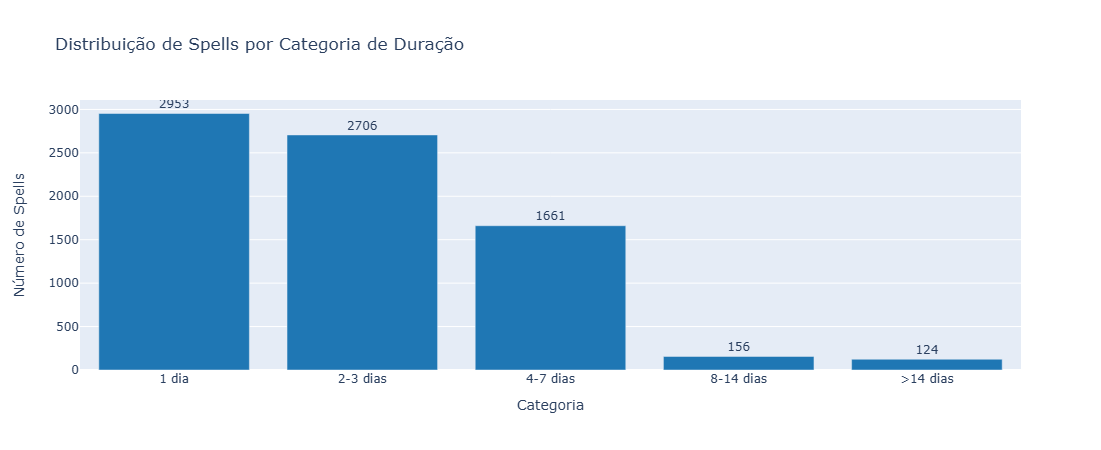

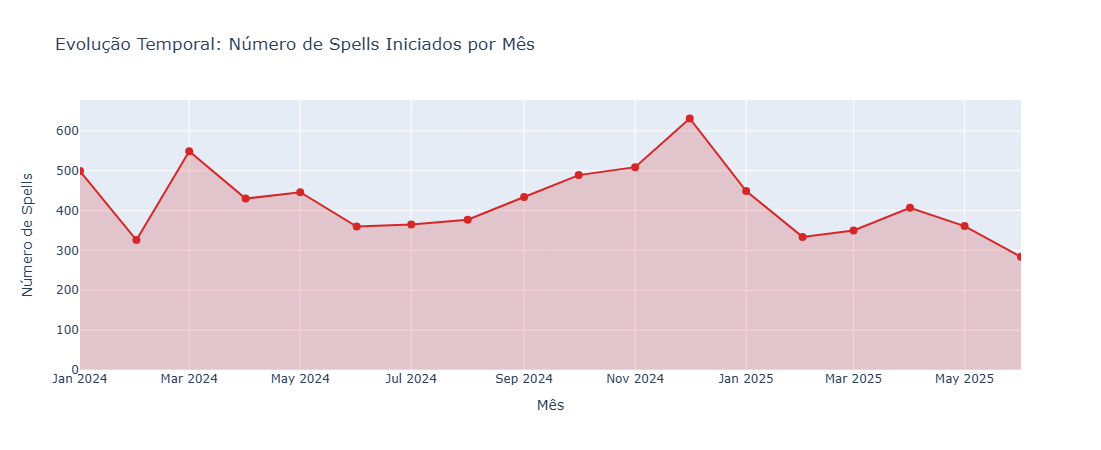

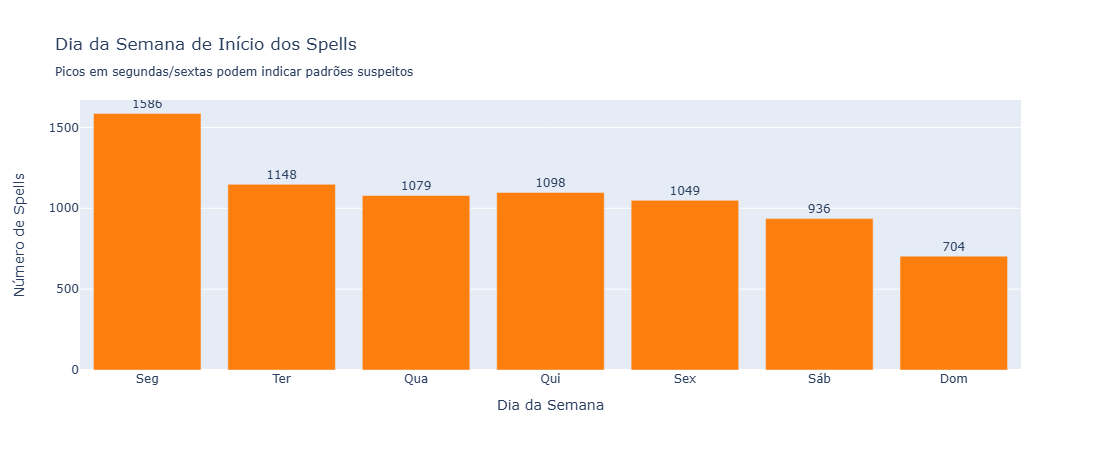

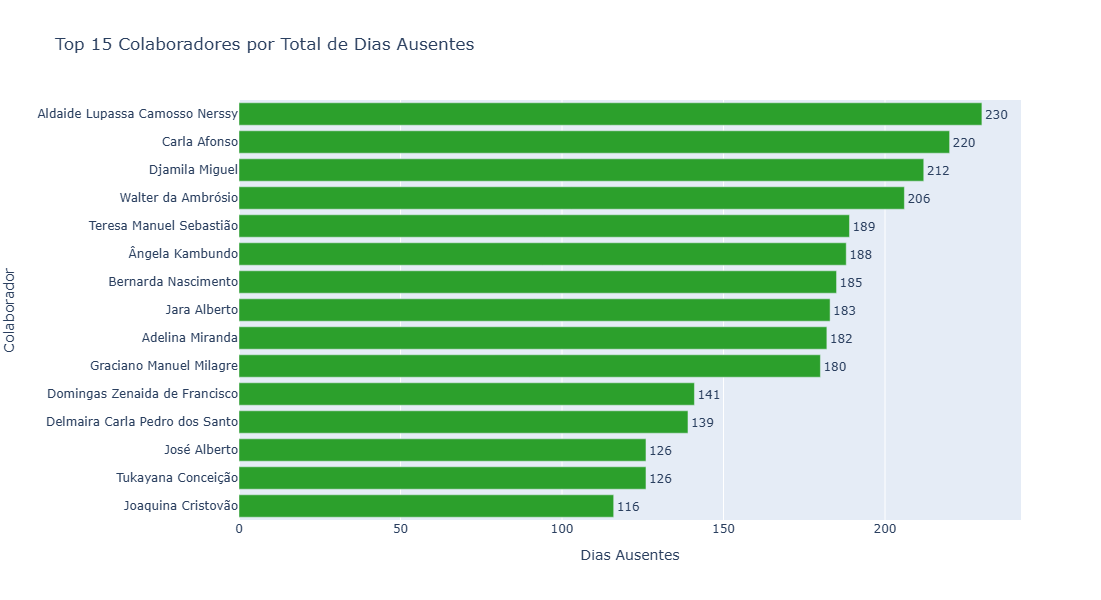

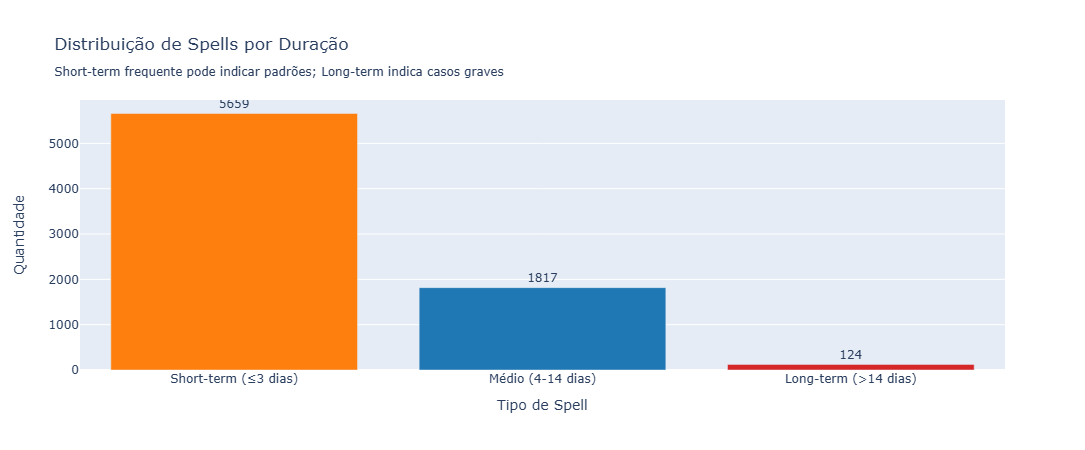


✓ Visualizações de spells criadas


In [68]:
# VIZ 1: Distribuição de duração de spells
cat_counts = df_spells['categoria_spell'].value_counts().sort_index()

fig1_alt = go.Figure()
fig1_alt.add_trace(go.Bar(
    x=cat_counts.index,
    y=cat_counts.values,
    marker_color='#1f77b4',
    text=cat_counts.values,
    textposition='outside'
))
fig1_alt.update_layout(
    title='Distribuição de Spells por Categoria de Duração',
    xaxis_title='Categoria',
    yaxis_title='Número de Spells',
    height=450
)
fig1_alt.show()

# VIZ 2: Evolução temporal de spells (número de spells iniciados por mês)
df_spells_temp = df_spells.copy()
df_spells_temp['ano_mes'] = df_spells_temp['data_inicio'].dt.to_period('M').astype(str)
spells_por_mes = df_spells_temp.groupby('ano_mes').size().reset_index(name='num_spells')

fig2 = go.Figure()
fig2.add_trace(go.Scatter(
    x=spells_por_mes['ano_mes'],
    y=spells_por_mes['num_spells'],
    mode='lines+markers',
    line=dict(color='#d62728', width=2),
    marker=dict(size=8),
    fill='tozeroy',
    fillcolor='rgba(214,39,40,0.2)'
))
fig2.update_layout(
    title='Evolução Temporal: Número de Spells Iniciados por Mês',
    xaxis_title='Mês',
    yaxis_title='Número de Spells',
    height=450,
    hovermode='x unified'
)
fig2.show()

# VIZ 3: Spells por dia da semana de início
ordem_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
spells_por_dia = df_spells['dia_semana_inicio'].value_counts().reindex(ordem_dias, fill_value=0)

fig3 = go.Figure()
fig3.add_trace(go.Bar(
    x=['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom'],
    y=spells_por_dia.values,
    marker_color='#ff7f0e',
    text=spells_por_dia.values,
    textposition='outside'
))
fig3.update_layout(
    title='Dia da Semana de Início dos Spells<br><sub>Picos em segundas/sextas podem indicar padrões suspeitos</sub>',
    xaxis_title='Dia da Semana',
    yaxis_title='Número de Spells',
    height=450
)
fig3.show()

# VIZ 4: Top 15 colaboradores por dias ausentes (barras horizontais)
top15_colab = df_colab_spells.nlargest(15, 'total_dias_ausentes').sort_values('total_dias_ausentes')

fig4 = go.Figure()
fig4.add_trace(go.Bar(
    y=[nome[:30] for nome in top15_colab['nome_colaborador']],
    x=top15_colab['total_dias_ausentes'],
    orientation='h',
    marker_color='#2ca02c',
    text=top15_colab['total_dias_ausentes'].astype(int),
    textposition='outside'
))
fig4.update_layout(
    title='Top 15 Colaboradores por Total de Dias Ausentes',
    xaxis_title='Dias Ausentes',
    yaxis_title='Colaborador',
    height=600,
    margin=dict(l=200)
)
fig4.show()

# VIZ 5: Comparação Short-term vs Long-term spells
spell_types = pd.DataFrame({
    'Tipo': ['Short-term\n(≤3 dias)', 'Médio\n(4-14 dias)', 'Long-term\n(>14 dias)'],
    'Quantidade': [
        df_spells['short_term'].sum(),
        ((df_spells['duracao_dias'] > 3) & (df_spells['duracao_dias'] <= 14)).sum(),
        df_spells['long_term'].sum()
    ]
})

fig5 = go.Figure()
fig5.add_trace(go.Bar(
    x=spell_types['Tipo'],
    y=spell_types['Quantidade'],
    marker_color=['#ff7f0e', '#1f77b4', '#d62728'],
    text=spell_types['Quantidade'],
    textposition='outside'
))
fig5.update_layout(
    title='Distribuição de Spells por Duração<br><sub>Short-term frequente pode indicar padrões; Long-term indica casos graves</sub>',
    xaxis_title='Tipo de Spell',
    yaxis_title='Quantidade',
    height=450
)
fig5.show()

print('\n✓ Visualizações de spells criadas')
print('='*70)


Analisando padrão de início de spells short-term por dia da semana...


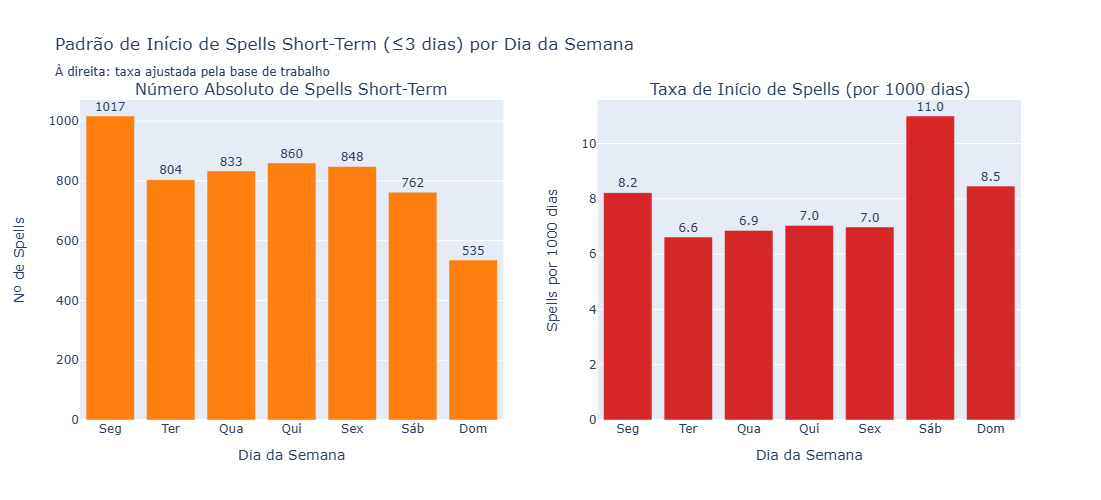


📊 Taxa de início de spells short-term (por 1000 dias de trabalho):

Dia       | Spells | Base      | Taxa (por 1000)
-------------------------------------------------------
Seg       |   1017 |   123,676 |            8.22
Ter       |    804 |   121,494 |            6.62
Qua       |    833 |   121,474 |            6.86
Qui       |    860 |   122,172 |            7.04
Sex       |    848 |   121,454 |            6.98
Sáb       |    762 |    69,295 |           11.00
Dom       |    535 |    63,235 |            8.46

⚠️  Dias com taxa acima da média (+10%): Sáb
   Possível padrão comportamental a investigar


In [69]:
# VIZ 3  Análise de spells short-term por dia da semana (com taxa ajustada)
print('\nAnalisando padrão de início de spells short-term por dia da semana...')

# Filtrar apenas spells short-term (≤3 dias)
df_spells_short = df_spells[df_spells['short_term'] == True].copy()

# Contar spells iniciados por dia da semana
ordem_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
spells_short_por_dia = df_spells_short['dia_semana_inicio'].value_counts().reindex(ordem_dias, fill_value=0)

# Calcular base (dias de trabalho) por dia da semana usando df_base_absentismo
base_por_dia = df_base_absentismo.groupby('Dia_Semana').size().reindex(ordem_dias, fill_value=0)

# Calcular taxa: spells iniciados por cada 1000 dias de trabalho
taxa_spells_por_dia = (spells_short_por_dia / base_por_dia * 1000).fillna(0)

# Criar gráfico comparativo
fig3 = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Número Absoluto de Spells Short-Term', 'Taxa de Início de Spells (por 1000 dias)'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}]]
)

# Subplot 1: Valores absolutos
fig3.add_trace(
    go.Bar(
        x=['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom'],
        y=spells_short_por_dia.values,
        marker_color='#ff7f0e',
        text=spells_short_por_dia.values,
        textposition='outside',
        name='Nº Spells'
    ),
    row=1, col=1
)

# Subplot 2: Taxa ajustada
fig3.add_trace(
    go.Bar(
        x=['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom'],
        y=taxa_spells_por_dia.values,
        marker_color='#d62728',
        text=[f'{v:.1f}' for v in taxa_spells_por_dia.values],
        textposition='outside',
        name='Taxa'
    ),
    row=1, col=2
)

fig3.update_xaxes(title_text="Dia da Semana", row=1, col=1)
fig3.update_xaxes(title_text="Dia da Semana", row=1, col=2)
fig3.update_yaxes(title_text="Nº de Spells", row=1, col=1)
fig3.update_yaxes(title_text="Spells por 1000 dias", row=1, col=2)

fig3.update_layout(
    title_text='Padrão de Início de Spells Short-Term (≤3 dias) por Dia da Semana<br><sub>À direita: taxa ajustada pela base de trabalho</sub>',
    height=500,
    showlegend=False
)

fig3.show()

# Mostrar insights
print('\n📊 Taxa de início de spells short-term (por 1000 dias de trabalho):')
print('\nDia       | Spells | Base      | Taxa (por 1000)')
print('-' * 55)
dias_pt = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
for i, dia in enumerate(ordem_dias):
    print(f'{dias_pt[i]:9s} | {spells_short_por_dia[dia]:6.0f} | {base_por_dia[dia]:9,} | {taxa_spells_por_dia[dia]:15.2f}')

# Identificar dias com taxa anormalmente alta
taxa_media = taxa_spells_por_dia.mean()
dias_suspeitos = [dias_pt[i] for i, taxa in enumerate(taxa_spells_por_dia.values) if taxa > taxa_media * 1.1]

if dias_suspeitos:
    print(f'\n⚠️  Dias com taxa acima da média (+10%): {", ".join(dias_suspeitos)}')
    print('   Possível padrão comportamental a investigar')

In [70]:
df_spells.columns

Index(['spell_id', 'login_colaborador', 'nome_colaborador',
       'categoria_profissional', 'data_inicio', 'data_fim', 'duracao_dias',
       'nivel1_predominante', 'nivel2_predominante', 'operacao',
       'dia_semana_inicio', 'dia_semana_fim', 'mes', 'ano', 'categoria_spell',
       'short_term', 'long_term'],
      dtype='object')

In [71]:
def analisar_spells_por_periodo(df, titulo_suffix=""):
    # Adicionar dia do mês
    df['dia_mes'] = df['data_inicio'].dt.day

    # Categorizar em períodos de 3 dias
    def categorizar_periodo_mes(dia):
        if dia <= 3: return '01. Dias 1-3'
        elif dia <= 6: return '02. Dias 4-6'
        elif dia <= 9: return '03. Dias 7-9'
        elif dia <= 12: return '04. Dias 10-12'
        elif dia <= 15: return '05. Dias 13-15'
        elif dia <= 18: return '06. Dias 16-18'
        elif dia <= 21: return '07. Dias 19-21'
        elif dia <= 24: return '08. Dias 22-24'
        elif dia <= 27: return '09. Dias 25-27'
        else: return '10. Dias 28-31'

    df['periodo_mes'] = df['dia_mes'].apply(categorizar_periodo_mes)

    # Contagem
    spells_por_periodo = df['periodo_mes'].value_counts().sort_index()

    # Base de absentismo
    df_base_temp = df_base_absentismo.copy()
    df_base_temp['dia_mes'] = df_base_temp['Data'].dt.day
    df_base_temp['periodo_mes'] = df_base_temp['dia_mes'].apply(categorizar_periodo_mes)

    base_por_periodo = df_base_temp.groupby('periodo_mes').size()

    # Taxa
    taxa_spells_periodo = (spells_por_periodo / base_por_periodo * 1000).fillna(0)

    # ---- GRÁFICOS (igual ao teu) ----
    fig_mes = make_subplots(
        rows=1, cols=2,
        subplot_titles=(f'Número Absoluto {titulo_suffix}',
                        f'Taxa de Início {titulo_suffix} (por 1000 dias)'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}]]
    )

    colors = ['#d62728' if i in [0, 9] else '#1f77b4' for i in range(10)]

    fig_mes.add_trace(
        go.Bar(
            x=spells_por_periodo.index,
            y=spells_por_periodo.values,
            text=spells_por_periodo.values,
            textposition='outside'
        ),
        row=1, col=1
    )

    fig_mes.add_trace(
        go.Bar(
            x=taxa_spells_periodo.index,
            y=taxa_spells_periodo.values,
            marker_color=colors,
            text=[f'{v:.1f}' for v in taxa_spells_periodo.values],
            textposition='outside'
        ),
        row=1, col=2
    )

    fig_mes.update_layout(height=500, showlegend=False)
    fig_mes.show()

    # ---- Insights ----
    taxa_inicio = taxa_spells_periodo['01. Dias 1-3']
    taxa_fim = taxa_spells_periodo['10. Dias 28-31']
    periodos_meio = [p for p in taxa_spells_periodo.index
                     if p not in ['01. Dias 1-3', '10. Dias 28-31']]
    taxa_meio = taxa_spells_periodo[periodos_meio].mean()

    print('\n📈 Comparação:')
    print(f'   Início: {taxa_inicio:.2f}')
    print(f'   Meio:   {taxa_meio:.2f}')
    print(f'   Fim:    {taxa_fim:.2f}')


##### Só short term

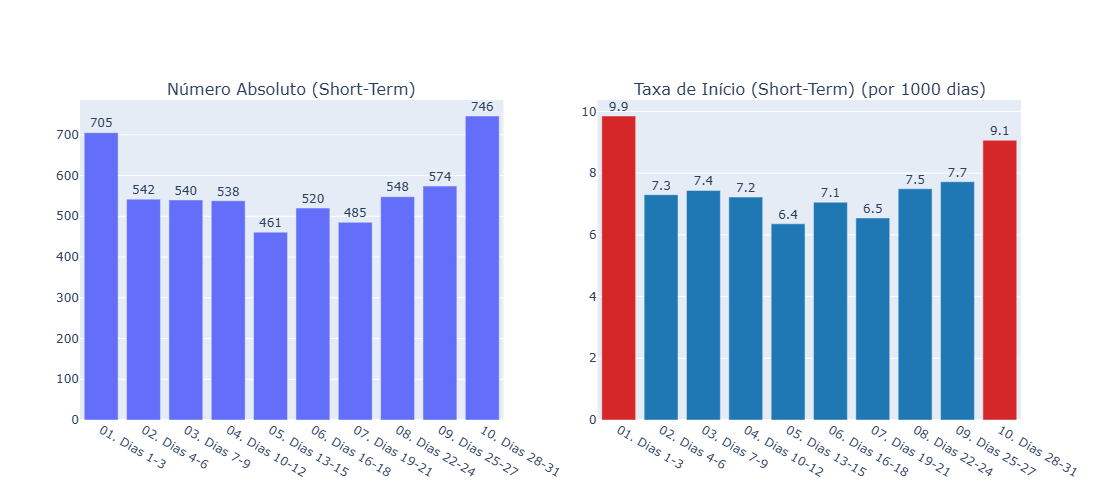


📈 Comparação:
   Início: 9.85
   Meio:   7.14
   Fim:    9.07


In [73]:
df_short = df_spells[df_spells['short_term'] == True].copy()
analisar_spells_por_periodo(df_short, "(Short-Term)")


##### Só Assistentes e short term

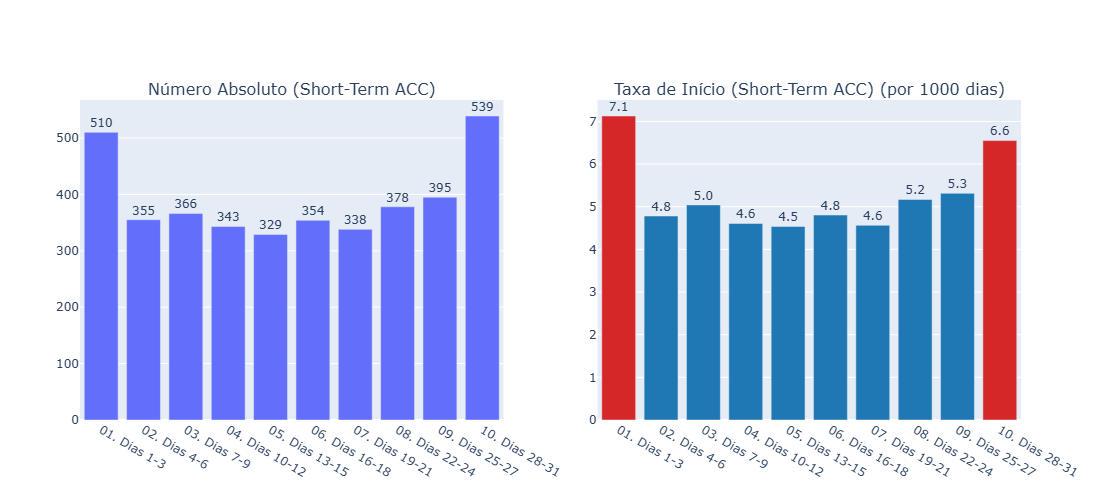


📈 Comparação:
   Início: 7.13
   Meio:   4.85
   Fim:    6.55


In [75]:
df_short_acc = df_spells[
    (df_spells['short_term'] == True) &
    (df_spells['categoria_profissional'] == "Assistente de Contact Center")
].copy()

analisar_spells_por_periodo(df_short_acc, "(Short-Term ACC)")


In [76]:
df_atrasos.shape

(761244, 17)

In [77]:
# ============================================================
# 4. MÉTRICAS CORE (KPIs Essenciais)
# ============================================================

print('\n=== MÉTRICAS CORE (Visão Global) ===')

# Período de análise
data_inicio = df_base_absentismo['Data'].min()
data_fim = df_base_absentismo['Data'].max()
dias_calendario = (data_fim - data_inicio).days + 1

print(f'Período analisado: {data_inicio.date()} até {data_fim.date()} ({dias_calendario} dias)')

# Total de colaboradores únicos
colabs = df_base_absentismo['login_colaborador'].nunique()
print(f'Colaboradores analisados: {colabs:,}')

# Total de faltas
total_faltas = len(df_faltas)

# Total de trabalho pago (presença)
total_trabalho_pago = len(df_absentismo[df_absentismo['Nivel 1'] == 'Trabalho Pago'])

# Base total
total_base = total_trabalho_pago + total_faltas

taxa_absentismo_global = (total_faltas / total_base * 100) if total_base > 0 else 0

print(f'\nTaxa de Absentismo Global: {taxa_absentismo_global:.2f}%')
print(f'Registos Trabalho Pago: {total_trabalho_pago:,}')
print(f'Registos Faltas: {total_faltas:,}')

# ------------------------------------------------------------
# Atrasos
# ------------------------------------------------------------


# Expandir Nivel 1 se existir lista
if isinstance(df_atrasos['Nivel 1'].iloc[0], list):
    df_atrasos = df_atrasos.explode('Nivel 1')

df_atrasos = df_atrasos[df_atrasos['Nivel 1'] == 'Atraso'].copy()

print(f'\nTotal de registos de Atraso: {len(df_atrasos):,}')

if len(df_atrasos) > 0:
    colabs_atrasos = df_atrasos['login_colaborador'].nunique()
    print(f'Colaboradores com atrasos: {colabs_atrasos:,}')
    pct_atrasos = (colabs_atrasos / colabs * 100)
    print(f'% da base com atrasos: {pct_atrasos:.2f}%')
else:
    print('Nenhum atraso registrado.')

# ------------------------------------------------------------
# Recorrência (quantidade de spells por colaborador)
# ------------------------------------------------------------
spells_por_colab = df_spells.groupby('login_colaborador').size()
media_spells = spells_por_colab.mean()

print(f'\nMédia de spells por colaborador: {media_spells:.2f}')

freq_acima_3 = (spells_por_colab > 3).mean() * 100
print(f'% colaboradores com mais de 3 spells: {freq_acima_3:.2f}%')

print('\n=== FIM do Grupo 4 ===')



=== MÉTRICAS CORE (Visão Global) ===
Período analisado: 2024-01-01 até 2025-06-30 (547 dias)
Colaboradores analisados: 3,131

Taxa de Absentismo Global: 3.30%
Registos Trabalho Pago: 718,289
Registos Faltas: 24,511

Total de registos de Atraso: 38,154
Colaboradores com atrasos: 2,258
% da base com atrasos: 72.12%

Média de spells por colaborador: 3.81
% colaboradores com mais de 3 spells: 39.36%

=== FIM do Grupo 4 ===
